In [323]:
#importing libraries
library(ggplot2)
library(dplyr)
library(forcats)
library(boot)
options(digits=8)
set.seed(42)

In [324]:
#quick look at data structure
data = read.csv('marketing_AB.csv')
head(data)

,X,user.id,test.group,converted,total.ads,most.ads.day,most.ads.hour
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>
1,0,1069124,ad,False,130,Monday,20
2,1,1119715,ad,False,93,Tuesday,22
3,2,1144181,ad,False,21,Tuesday,18
4,3,1435133,ad,False,355,Tuesday,10
5,4,1015700,ad,False,276,Friday,14
6,5,1137664,ad,False,734,Saturday,10


In [325]:
#check for dublicates
n_occur <- data.frame(table(data$user.id))
n_occur[n_occur$Freq > 1,]

Var1,Freq
<fct>,<int>


In [326]:
#check for null values
sum(is.na(data))

[1] 0

In [327]:
#distribution of test groups
data %>% group_by(test.group) %>%
         summarise(n = n()) %>%
         mutate(freq = n / sum(n))

test.group,n,freq
<chr>,<int>,<dbl>
ad,564577,0.960000068
psa,23524,0.039999932


In [328]:
#splitting into test and control group
indexes_treatment = which(data['test.group'] == 'ad')
treatment_group <- data[indexes_treatment, ]
head(treatment_group)

,X,user.id,test.group,converted,total.ads,most.ads.day,most.ads.hour
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>
1,0,1069124,ad,False,130,Monday,20
2,1,1119715,ad,False,93,Tuesday,22
3,2,1144181,ad,False,21,Tuesday,18
4,3,1435133,ad,False,355,Tuesday,10
5,4,1015700,ad,False,276,Friday,14
6,5,1137664,ad,False,734,Saturday,10


In [329]:
indexes_control = which(data['test.group'] != 'ad')
control_group <- data[indexes_control, ]
head(control_group)

,X,user.id,test.group,converted,total.ads,most.ads.day,most.ads.hour
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>
19,18,900681,psa,False,248,Saturday,19
39,38,905704,psa,False,27,Thursday,8
69,68,904595,psa,False,13,Tuesday,19
141,140,901904,psa,False,32,Wednesday,19
158,157,902234,psa,False,105,Tuesday,19
168,167,906079,psa,False,37,Monday,10


In [330]:
#let's check that experiment was equal to both groups
#at first let's check that the distribution of weekdays is similar between groups
days <- data %>%
        group_by(test.group, most.ads.day) %>%
        summarise(n = n()) %>%
        mutate(freq = n / sum(n))

`summarise()` has grouped output by 'test.group'. You can override using the
`.groups` argument.


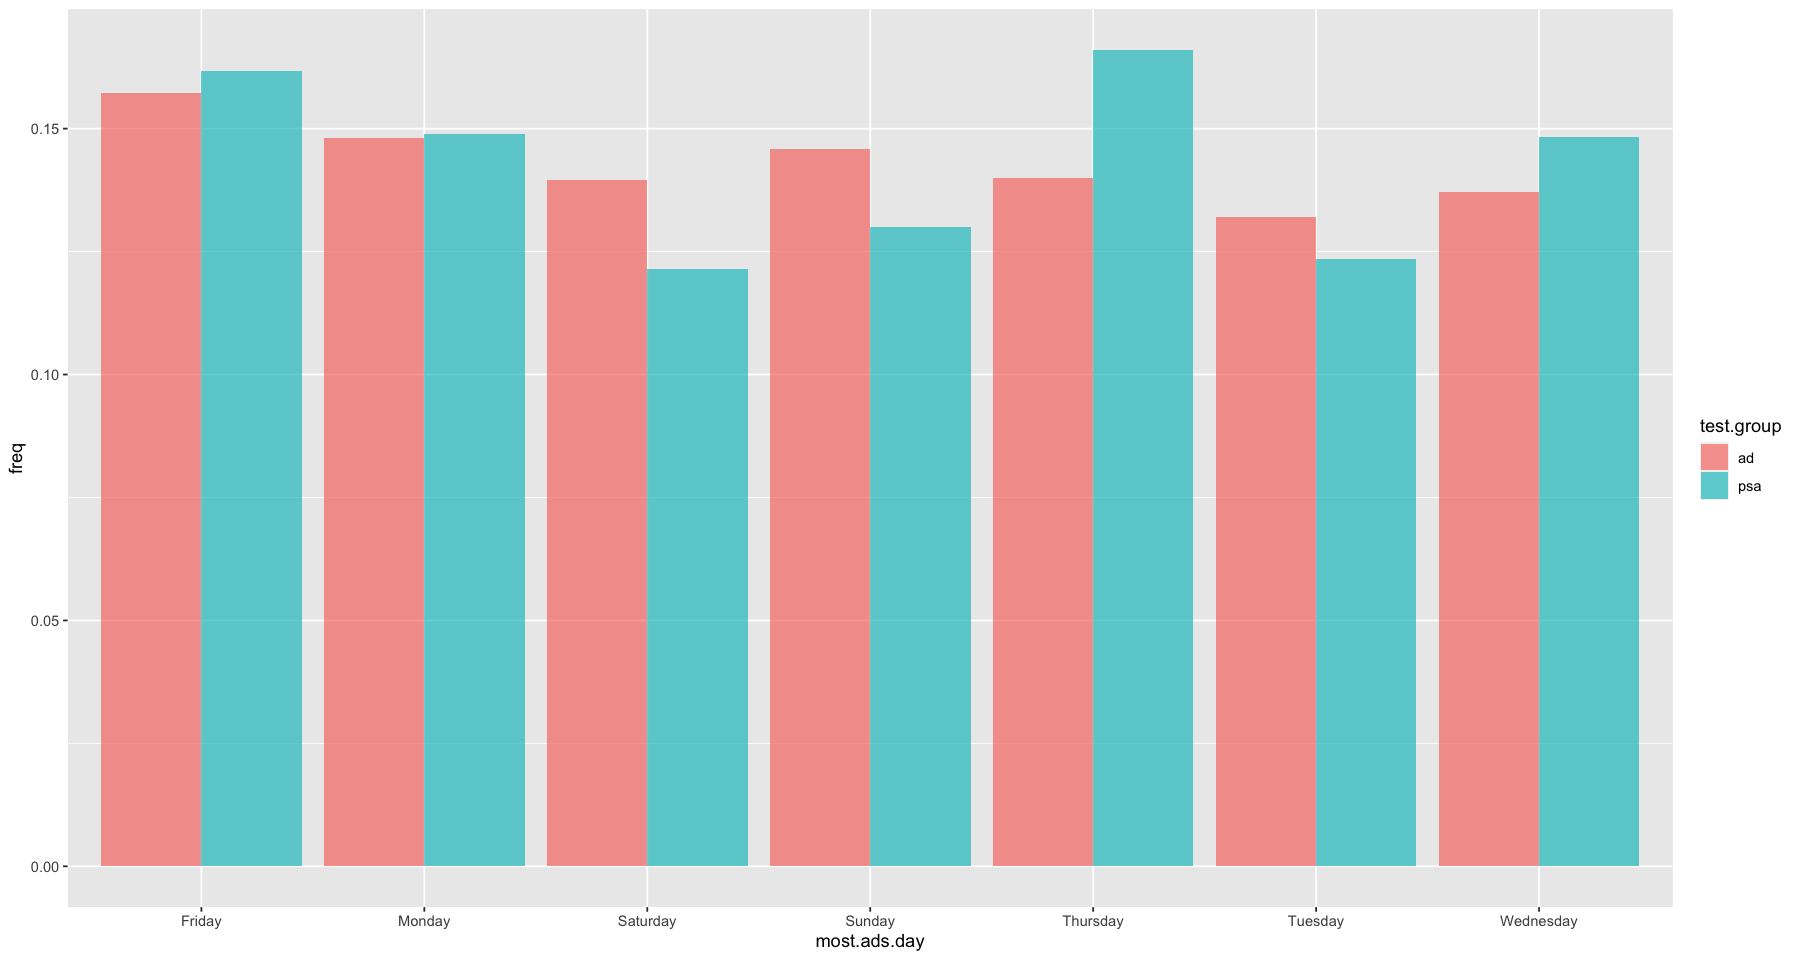

In [343]:
#distribution between groups is similiar
options(repr.plot.width=15, repr.plot.height=8)

ggplot(days, aes(x = most.ads.day, y = freq, fill = test.group)) +
geom_bar(stat = 'identity', position = 'dodge', alpha = 2/3)

In [332]:
#count success convertions for each group
success <- data[which(data['converted'] == 'True'),] %>%
        group_by(test.group) %>%
        summarise(n = n())

In [333]:
#count total amount for each group
total <- data %>%
        group_by(test.group) %>%
        summarise(n = n())

In [334]:
#p-value is significantly low, we reject hypothesis that the convertion rate is equal between test and control group
#the effect of the advertisement is from 0.5% to 0.9%
prop.test(x = unlist(success['n']), n = unlist(total['n']), cor = F)


	2-sample test for equality of proportions without continuity
	correction

data:  unlist(success["n"]) out of unlist(total["n"])
X-squared = 54.3181, df = 1, p-value = 1.7053e-13
alternative hypothesis: two.sided
95 percent confidence interval:
 0.0059509324 0.0094339740
sample estimates:
     prop 1      prop 2 
0.025546560 0.017854106 


In [335]:
#however we have to be sure that groups are splitted without bias
#there is a chance that treatment group see more ads on average and thus ads work better on this group
#we can see that treatment group has more ads seen on average, let's figure out if it's stat significant
mean(control_group$total.ads)
mean(treatment_group$total.ads)

[1] 24.761138

[1] 24.823365

In [336]:
#H0: avg number of ads seen are equal
#p-value is high and we do not reject hypothesis
t.test(control_group$total.ads, treatment_group$total.ads, alternative = "less", var.equal = FALSE)


	Welch Two Sample t-test

data:  control_group$total.ads and treatment_group$total.ads
t = -0.217997, df = 25607.8, p-value = 0.41372
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf 0.40731535
sample estimates:
mean of x mean of y 
24.761138 24.823365 


In [337]:
#let's assume there are small samples and we are pretty unsure about normality of the sample mean
#for that let's randomly select 100 rows from each group, assuming test had 200 participants
X_test <- as.vector(data$total.ads[data$test.group == 'ad'])
X_control <- as.vector(data$total.ads[data$test.group == 'psa'])
small_test = sample(X_test, 100, replace = FALSE)
small_control = sample(X_control, 100, replace = FALSE)

In [338]:
result_test <- t.test(small_control, small_test, alternative = "less", var.equal = FALSE)
print(result_test)


	Welch Two Sample t-test

data:  small_control and small_test
t = -0.301115, df = 168.745, p-value = 0.38185
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf 7.8172924
sample estimates:
mean of x mean of y 
    24.86     26.60 



In [339]:
#let's find bootstrap estimation for p-value

p_test_function <- function(data_func, t_stat) {
    
    fake_test <- data_func[1:100]
    fake_control <- data_func[100:200]

    t_test <- t.test(fake_control, fake_test, alternative = "less", var.equal = FALSE)
    
    result <- if (t_test$statistic <= t_stat) {1}
              else {0}
    
    return (result)
}

In [340]:
#bootstrap simulation with 100000
#combining 2 samples into 1 which represents population and simulate the same test assuming H0 is true
#count how many times it gives result as extreme as ours 
B <- 100000
bootstrap_result <- replicate(B, {
  X <- c(small_test, small_control)
  N <- 200
  samp <- sample(X, N, replace = TRUE)
  p_test_function(samp, result_test$statistic)
})

In [341]:
#bootstrap estimation of 100000 samples tells us that p-value is 0.38872
#so we have even less motivation to reject H0: equal amount of ads seen
sum(bootstrap_result)/B

[1] 0.38872

In [342]:
#conclusion: there are no reasons to think that test was biased in terms of groups/timings
#with that in mind, there is significant difference between test and treatment group
#it's reasonable to believe that the effect of the advertisement is from 0.5% to 0.9%